In [82]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import importlib
from xgboost import XGBClassifier, plot_importance

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *

In [81]:
import auxFuns.modelling 
importlib.reload(auxFuns.modelling)

<module 'auxFuns.modelling' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\modelling.py'>

# 1. Exploration of ML algorithms and visualization of their decision boundaries
- Fitting various ML algorithms (linear, tree-based, distance-based)
- Interpretability and explanation

In [6]:
# Load data sets under study (VSCode)
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_phase1_df = pd.read_csv(raw_datasets_path + '/rsv_predictors_df_phase1_v3.csv')
rsv_predictors_phase1_daysDedup_df = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup.csv',low_memory=False)

# Load data sets under study (GColab)
# rsv_predictors_phase1_df = pd.read_csv('/content/rsv_predictors_df_phase1_v3.csv')
# rsv_predictors_phase1_daysDedup_df = pd.read_csv('/content/rsv_predictors_phase1_daysDedup.csv', low_memory=False)

In [7]:
rsv_predictors_phase1_df = make_it_categorical(rsv_predictors_phase1_df)
rsv_predictors_phase1_daysDedup_df = make_it_categorical(rsv_predictors_phase1_daysDedup_df)

rsv_predictors_phase1_df.shape, rsv_predictors_phase1_daysDedup_df.shape

# Extract a reduced sample of the data for modelling
sample_size = 10000
sample_rsv_df = rsv_predictors_phase1_df.sample(n = sample_size)
sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.sample(n = sample_size)

# sample_rsv_df = rsv_predictors_phase1_df.copy()
# sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.copy()

In [8]:
sample_rsv_df['RSV_test_result'].value_counts(), sample_dedup_rsv_df['RSV_test_result'].value_counts()

(RSV_test_result
 Negative    9688
 Positive     312
 Name: count, dtype: int64,
 RSV_test_result
 Negative    9728
 Positive     272
 Name: count, dtype: int64)

In [14]:
# 1. Transform the data and prepare it for modelling
df1 = sample_dedup_rsv_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters'], axis = 1)

X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_rsv(df1, 
                                                                          input_test_size = 0.2, random_seed = 42
                                                                          )

In [13]:
# Transform the data using resampling: SMOTE-NC
X_train_transformed_smote, y_train_smote, X_test_transformed_smote, y_test_smote, preprocessor_rsv = preprocess_and_resample_rsv(
    df1, input_test_size = 0.2, random_seed = 42, resampling_technique = 'over', ratio_maj_min = 0.1)

Resampling method chosen:

Oversampling


## 1.1. Random forest

In [38]:
# 2. Fit the model, specyfing a) model class b) hyperparameter_grid, target_scorer, number of cross-validation folds
random_seed = 42
cost_sensitive = True

if cost_sensitive:
    weight_dict = {"Negative": 1,
                   "Positive": 5}
    model_class = RandomForestClassifier(class_weight= weight_dict,
                                         random_state= random_seed)
else:
    model_class = RandomForestClassifier(class_weight= None,
                                         random_state= random_seed)
    
param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, average='macro')
n_cv_folds = 5

model1 = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train)


Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 5},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.6225102981153129


Optimal threshold: 0.37
Optimal f1: 0.30769230769230765


AUC Score: 0.7314075035786811
Precision / Positive predictive value: 0.75
Specificity: 0.9979360165118679
Recall / sensitivity: 0.1935483870967742
Negative predictive value: 0.9747983870967742
Accuracy: 0.973
F-1: 0.30769230769230765


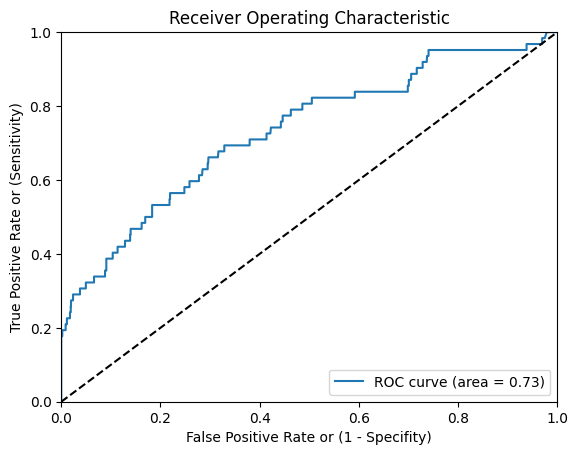

In [39]:
# 4. Obtain optimal threshold and evaluate the resulting model
optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test_transformed, y_test = y_test)


__,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = True)

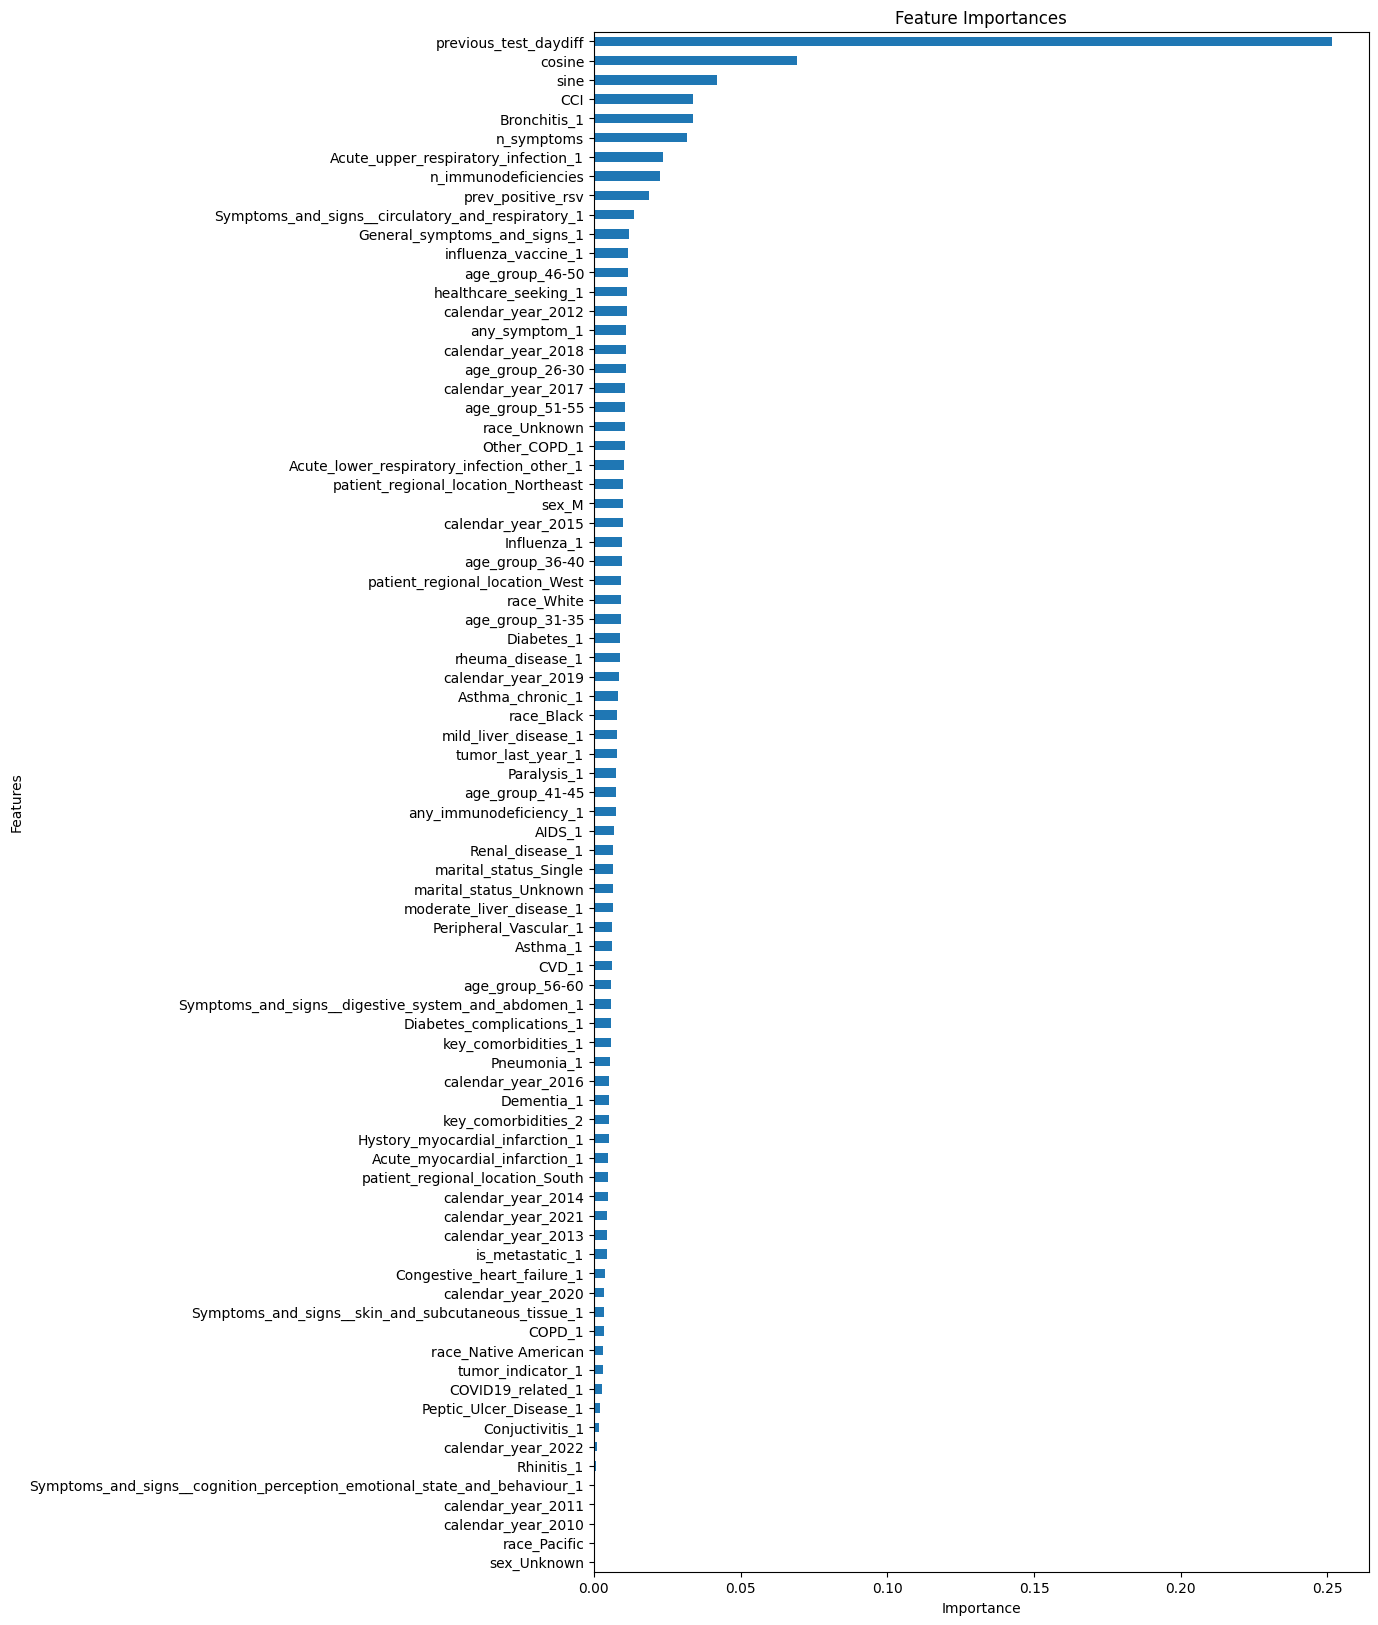

In [25]:
# Observe the feature importances plot to detect potential inconsistencies
plot_feature_importance_rf_rsv(preprocessor_rsv, trained_model = model1)

# 1.2. XGBoost

In [57]:
random_seed = 42
cost_sensitive = True

if cost_sensitive:
    weight_dict = {"Negative": 1,
                   "Positive": 50}
    scale_pos_weight = weight_dict["Positive"]/weight_dict["Negative"]  # Use scale_pos_weight parameter
    model_class = XGBClassifier(scale_pos_weight=scale_pos_weight,
                                random_state=random_seed)
else:
    model_class = XGBClassifier(random_state=random_seed)

param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_child_weight': [1, 5], 
    'gamma': [0, 0.1] 
}

target_scorer = make_scorer(f1_score, average='macro')
n_cv_folds = 5

# XGBoost needs labels in numeric format
y_train_numeric = [1 if label == "Positive" else 0 for label in y_train]

model1_xgb = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train_numeric)

Training model ... XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Best training parameters:  {'gamma': 0.1, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 14}
Best training f1-score:  0.6009784915917694


Optimal threshold: 0.81
Optimal f1: 0.345679012345679


AUC Score: 0.7214288092146875
Precision / Positive predictive value: 0.7368421052631579
Specificity: 0.9974200206398349
Recall / sensitivity: 0.22580645161290322
Negative predictive value: 0.9757698132256436
Accuracy: 0.9735
F-1: 0.345679012345679


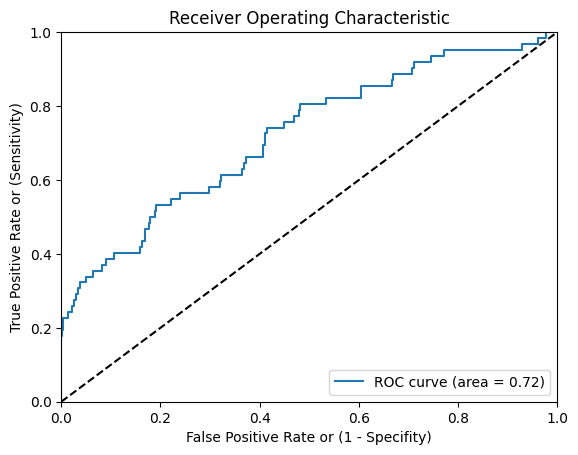

In [58]:
# 4. Obtain optimal threshold and evaluate the resulting model
optimal_threshold = find_optimal_moving_threshold(model = model1_xgb, X_test = X_test_transformed, y_test = y_test)


__,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1_xgb, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = True)

In [76]:
# Print feature importance
importance = model1_xgb.best_estimator_.feature_importances_
# for i, j in enumerate(importance):
#     print(X_train_transformed.columns[i], ":", j)

# # Or in sorted order
# sorted_idx = np.argsort(importance)[::-1]
# for i in sorted_idx:
#     print(X_train_transformed.columns[i], ":", importance[i])
importance

array([0.00725412, 0.        , 0.01078615, 0.0336246 , 0.        ,
       0.00774167, 0.00789064, 0.00938646, 0.0086032 , 0.00510029,
       0.00773476, 0.01299655, 0.00804519, 0.01012891, 0.00641933,
       0.01708646, 0.00825209, 0.00557993, 0.01408488, 0.03558811,
       0.01403187, 0.0193595 , 0.00579341, 0.0740796 , 0.01809933,
       0.00889321, 0.01470084, 0.01129159, 0.01544173, 0.01761604,
       0.00348479, 0.01808571, 0.01446307, 0.01206611, 0.0163628 ,
       0.01477447, 0.00877175, 0.00605001, 0.0088132 , 0.01233146,
       0.00483   , 0.00927111, 0.01385973, 0.00760727, 0.01970399,
       0.01376261, 0.0095256 , 0.01212572, 0.01186316, 0.00923274,
       0.00945188, 0.00958807, 0.00969649, 0.00602377, 0.00841034,
       0.01440531, 0.00588483, 0.00765951, 0.01036153, 0.00262596,
       0.        , 0.        , 0.01545416, 0.01101805, 0.01644859,
       0.01205829, 0.0192203 , 0.00457822, 0.00578594, 0.01466051,
       0.00564278, 0.05943218, 0.00611395, 0.01091462, 0.00944

## 1.3. Stacking model

In [63]:
# Define the base models
weight_dict = {0: 1, 1:10}
level0 = list()
level0.append(('rf', RandomForestClassifier(class_weight=weight_dict, random_state=random_seed)))
level0.append(('xgb', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=random_seed)))

# Define meta learner model
level1 = LogisticRegression()

# Define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# Fit the model on all available data
model.fit(X_train_transformed, y_train_numeric)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight={0: 1,
                                                                     1: 10},
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None,...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...))],
                   final_estimator=LogisticRegression())

Optimal threshold: 0.19
Optimal f1: 0.3023255813953488


AUC Score: 0.7354772129564899
Precision / Positive predictive value: 0.5416666666666666
Specificity: 0.9943240454076367
Recall / sensitivity: 0.20967741935483872
Negative predictive value: 0.9752024291497976
Accuracy: 0.97
F-1: 0.3023255813953488


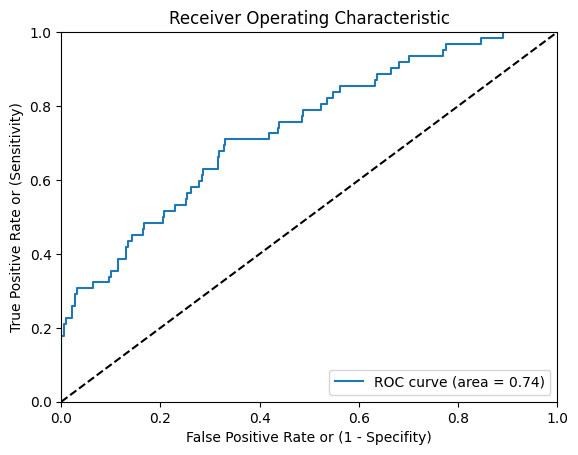

In [64]:
optimal_threshold = find_optimal_moving_threshold(model = model, X_test = X_test_transformed, y_test = y_test)


__,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = True)

# 2. Granular approach
Build-up of individual models according to two different flags:
- Season: 4 categories == 4 models
- Multiple_tests: yes/no == 2 models
- Third level: differentiate between 8 categories, i.e. combination of season and multiple_tests == 8 models

In [61]:
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

rsv_predictors_df_v2.shape

# summary_function_rsv(rsv_predictors_df_v2)

# Extract a reduced sample of the data for modelling
sample_size = 10000
sample_v2_df = rsv_predictors_df_v2.sample(n = sample_size)

In [7]:
sample_v2_df['season'].value_counts()

season
winter    4560
spring    3173
autumn    1563
summer     704
Name: count, dtype: int64

### 2.1. Taking the year's season as separate intervals

In [ ]:
df1 = sample_v2_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters', 'n_tests_that_day'], axis = 1)

model_dict = {'winter': None,
              'spring': None,
              'summer': None,
              'autumn': None}

for s in ['winter', 'spring', 'summer', 'autumn']:
    print('\n----------------------------------------')
    print(f'\n Entering the loop for {s} ...')
    X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_and_resample_flag_rsv(df1, 
                                                                            input_test_size = 0.2, random_seed = 42,
                                                                            flag_column= 'season', flag_value = s
                                                                            )
    

    # Train a model speficic to every season
    random_seed = 42
    cost_sensitive = False

    if cost_sensitive:
        weight_dict = {"Negative": 1,
                    "Positive": 5}
        model_class = RandomForestClassifier(class_weight= weight_dict,
                                            random_state= random_seed)
    else:
        model_class = RandomForestClassifier(class_weight= None,
                                            random_state= random_seed)
        
    param_grid = {
        'n_estimators': [4, 7, 14, 25],
        'max_depth': [10, 20],
        'min_samples_split': [3, 5, 10],
        'min_samples_leaf': [2, 4]
    }
    target_scorer = make_scorer(f1_score, pos_label='Positive')
    # target_scorer = make_scorer(f1_score, average='binary', pos_label = 'Positive')
    # target_scorer = make_scorer(average_precision_score, needs_proba=True, pos_label = 'Positive')

    n_cv_folds = 5

    model1 = train_model_flag_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                        X_train = X_train_transformed, y_train = y_train, flag_value = s)
    

    # Store the season-specific model
    model_dict[s] = model1


    # Add in the same for the evaluation of the model, to allow for all results to come at once
    optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test_transformed, y_test = y_test)

    __,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = False)
        

### 2.2. Taking the presence of multiple tests as flag

In [ ]:
df1 = sample_v2_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters', 'n_tests_that_day'], axis = 1)

model_dict = {'only_one': None,
              'multiple': None}

for s in [True, False]:
    
    print('\n----------------------------------------')
    print(f'\n Entering the loop for {s} ...')
    X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_and_resample_flag_rsv(df1, 
                                                                            input_test_size = 0.2, random_seed = 42,
                                                                            flag_column= 'multiple_tests', flag_value = s
                                                                            )
    

    # Train a model speficic to every season
    random_seed = 42
    cost_sensitive = False

    if cost_sensitive:
        weight_dict = {"Negative": 1,
                    "Positive": 5}
        model_class = RandomForestClassifier(class_weight= weight_dict,
                                            random_state= random_seed)
    else:
        model_class = RandomForestClassifier(class_weight= None,
                                            random_state= random_seed)
        
    param_grid = {
        'n_estimators': [4, 7, 14, 25],
        'max_depth': [10, 20],
        'min_samples_split': [3, 5, 10],
        'min_samples_leaf': [1, 4]
    }
    # target_scorer = make_scorer(f1_score, average='weighted')
    target_scorer = make_scorer(f1_score, average='binary', pos_label = 'Positive')
    # target_scorer = make_scorer(average_precision_score, needs_proba=True, pos_label = 'Positive')

    n_cv_folds = 5

    model1 = train_model_flag_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                        X_train = X_train_transformed, y_train = y_train, flag_value = s)
    

    # Store the season-specific model
    if s:
        s_label = "multiple"
    else:
        s_label = "only_one"

    model_dict[s_label] = model1


    # Add in the same for the evaluation of the model, to allow for all results to come at once
    optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test_transformed, y_test = y_test)

    __,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = False)

### 2.3 Taking the combination of season and previous test as flag

In [137]:
# Build a new column for every combination of season-multiple_tests
 
df1 = sample_v2_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters', 'n_tests_that_day'], axis = 1)

def get_season_multiple_tests_rsv(season, multiple_tests):
    if (multiple_tests == False) and (season == 'winter'):
        return 'winterFalse'
    elif (multiple_tests == False) and (season == 'spring'):
        return 'springFalse'
    elif (multiple_tests == False) and (season == 'summer'):
        return 'summerFalse'
    elif (multiple_tests == False) and (season == 'autumn'):
        return 'autumnFalse'
    elif (multiple_tests == True) and (season == 'winter'):
        return 'winterTrue'
    elif (multiple_tests == True) and (season == 'spring'):
        return 'springTrue'
    elif (multiple_tests == True) and (season == 'summer'):
        return 'summerTrue'
    elif (multiple_tests == True) and (season == 'autumn'):
        return 'autumnTrue'
    

df1['combination'] = pd.Categorical(df1.apply(lambda row: get_season_multiple_tests_rsv(row['season'], row['multiple_tests']), axis=1),
                                    categories = ['winterFalse','springFalse','summerFalse','autumnFalse',
                                                  'winterTrue', 'springTrue', 'summerTrue', 'autumnTrue' ])

In [ ]:
X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_and_resample_rsv(df1, 
                                                                            input_test_size = 0.2, random_seed = 42
                                                                            )
random_seed = 42
cost_sensitive = False

if cost_sensitive:
    weight_dict = {"Negative": 1,
                "Positive": 5}
    model_class = RandomForestClassifier(class_weight= weight_dict,
                                        random_state= random_seed)
else:
    model_class = RandomForestClassifier(class_weight= None,
                                        random_state= random_seed)
    
param_grid = {
    'n_estimators': [4, 7, 14, 25],
    'max_depth': [10, 20],
    'min_samples_split': [1, 5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, average='binary', pos_label = 'Positive')
# target_scorer = make_scorer(average_precision_score, needs_proba=True, pos_label = 'Positive')

n_cv_folds = 5

model1 = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train)



# Add in the same for the evaluation of the model, to allow for all results to come at once
optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test_transformed, y_test = y_test)

__,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test,
                                                        threshold = optimal_threshold, 
                                                        print_roc = False)

In [ ]:
# Now, make the new models for the combination of all

# model_dict = {'winter': None,
#               'spring': None,
#               'summer': None,
#               'autumn': None}
model_dict = {'winterFalse': None,'springFalse': None,'summerFalse': None,'autumnFalse': None,
                                                  'winterTrue': None, 'springTrue': None, 'summerTrue': None, 'autumnTrue': None }

# for s in ['winterFalse','springFalse','summerFalse','autumnFalse','winterTrue', 'springTrue', 'summerTrue', 'autumnTrue' ]:
for s in ['winterFalse','springFalse','autumnFalse','winterTrue', 'springTrue', 'summerTrue', 'autumnTrue' ]:
    
    print('\n----------------------------------------')
    print(f'Entering the loop for {s} ...')
    
    X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_and_resample_flag_rsv(df1, 
                                                                            input_test_size = 0.2, random_seed = 42,
                                                                            flag_column= 'combination', flag_value = s
                                                                            )
    

    # Train a model speficic to every season
    random_seed = 42
    cost_sensitive = False

    if cost_sensitive:
        weight_dict = {"Negative": 1,
                    "Positive": 5}
        model_class = RandomForestClassifier(class_weight= weight_dict,
                                            random_state= random_seed)
    else:
        model_class = RandomForestClassifier(class_weight= None,
                                            random_state= random_seed)
        
    param_grid = {
        'n_estimators': [4, 7, 14, 25],
        'max_depth': [10, 20],
        'min_samples_split': [1, 5, 10],
        'min_samples_leaf': [1, 4]
    }
    # target_scorer = make_scorer(f1_score, average='binary', pos_label = 'Positive')
    target_scorer = make_scorer(average_precision_score, needs_proba=True, pos_label = 'Positive')

    n_cv_folds = 5

    model1 = train_model_flag_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                        X_train = X_train_transformed, y_train = y_train, flag_value = s)
    

    # Store the season-specific model
    model_dict[s] = model1


    # Add in the same for the evaluation of the model, to allow for all results to come at once
    optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test_transformed, y_test = y_test)

    __,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = False)
        

# 3. Resampling after feature selection

Previous resampling attemps have resulted in a poorer performance in the past. This is likely to happen because of the amplification of non-relevant features, leading to overfitting to train data. After having selected specific features, this problem is expected to have been mitigated 

- random forest, LightGBM, XGBoost
- stacking models
- anomaly detection
- deep learning

In [62]:
selected_features = ['sex', 'marital_status', 'patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season']
# selected_features = ['sex', 'marital_status', 'patient_regional_location', 'age_group',
#                      'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
#                      'COPD','AIDS','Asthma_chronic','CCI',
#                      'sine','cosine','calendar_year', 
#                      'healthcare_seeking', 'influenza_vaccine',
#                      'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
#                      'tumor_indicator','tumor_last_year']
selected_features.append('RSV_test_result')

In [63]:
df1 = sample_v2_df[selected_features]

X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_and_resample_rsv(df1, 
                                                                          input_test_size = 0.3, random_seed = 42,
                                                                          resampling_technique='smotenc', ratio_maj_min=0.1
                                                                          )

Resampling method chosen:

SMOTE-sampling


Try with random forest !

In [47]:
random_seed = 42
cost_sensitive = True

if cost_sensitive:
    weight_dict = {"Negative": 1,
                   "Positive": 50}
    model_class = RandomForestClassifier(class_weight= weight_dict,
                                         random_state= random_seed)
else:
    model_class = RandomForestClassifier(class_weight= None,
                                         random_state= random_seed)
    
param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, average = 'binary', pos_label='Positive')
n_cv_folds = 5

model1 = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train)


Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 50},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 14}
Best training f1-score:  0.5294362179309914


Optimal threshold: 0.74
Optimal f1: 0.1466666666666667


AUC Score: 0.6695468830973437
Precision / Positive predictive value: 0.16176470588235295
Specificity: 0.9804660726525017
Recall / sensitivity: 0.13414634146341464
Negative predictive value: 0.9757844474761255
Accuracy: 0.9573333333333334
F-1: 0.1466666666666667


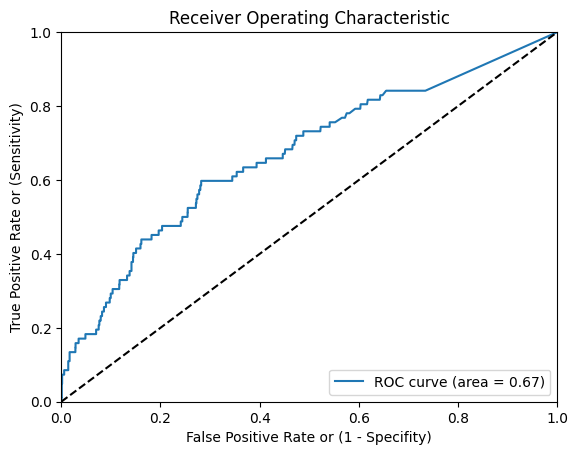

In [48]:
optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test_transformed, y_test = y_test)
__,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = True)

Try with XGBoost !

In [56]:
random_seed = 42
cost_sensitive = False

if cost_sensitive:
    weight_dict = {"Negative": 1,
                   "Positive": 50}
    scale_pos_weight = weight_dict["Positive"]/weight_dict["Negative"]  # Use scale_pos_weight parameter
    model_class = XGBClassifier(scale_pos_weight=scale_pos_weight,
                                random_state=random_seed)
else:
    model_class = XGBClassifier(random_state=random_seed)

param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_child_weight': [1, 5], 
    'gamma': [0, 0.1] 
}

# target_scorer = make_scorer(f1_score, average ='binary', pos_label = 'Positive')
target_scorer = make_scorer(recall_score, average='binary', pos_label = 1)

n_cv_folds = 5

# XGBoost needs labels in numeric format
y_train_numeric = [1 if label == "Positive" else 0 for label in y_train]

model1_xgb = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train_numeric)

Training model ... XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Best training parameters:  {'gamma': 0.1, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 14}
Best training f1-score:  0.5659081150708458


Optimal threshold: 0.52
Optimal f1: 0.21359223300970875


AUC Score: 0.7575143349103128
Precision / Positive predictive value: 0.5238095238095238
Specificity: 0.9965729952021933
Recall / sensitivity: 0.13414634146341464
Negative predictive value: 0.9761664988251091
Accuracy: 0.973
F-1: 0.21359223300970875


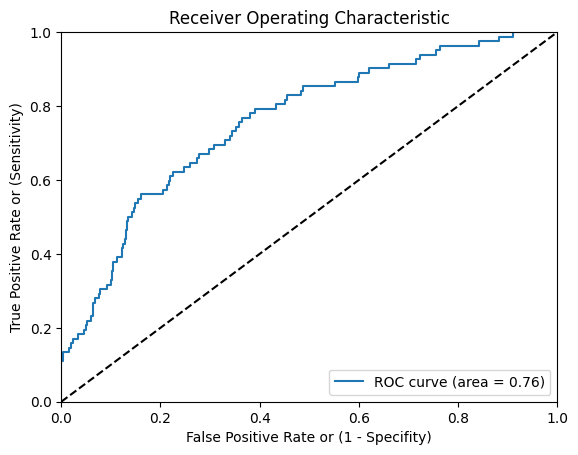

In [57]:
optimal_threshold = find_optimal_moving_threshold(model = model1_xgb, X_test = X_test_transformed, y_test = y_test)
__,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1_xgb, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = True)

Try Gaussian process!

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

model_dict = {'winter': None,
              'spring': None,
              'summer': None,
              'autumn': None}

for s in ['winter', 'spring', 'summer', 'autumn']:
    print('\n----------------------------------------')
    print(f'\n Entering the loop for {s} ...')
    X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_and_resample_flag_rsv(df1, 
                                                                            input_test_size = 0.2, random_seed = 42,
                                                                            flag_column= 'season', flag_value = s
                                                                            )
    
    # Train a model specific to every season
    random_seed = 42
    cost_sensitive = False

    # Define kernel for the Gaussian Process
    kernel = 1.0 * RBF(1.0)

    model_class = GaussianProcessClassifier(kernel=kernel, random_state=random_seed)

    param_grid = {
        "kernel": [1.0 * RBF(1.0), 1.0 * RBF(0.5), 1.0 * RBF(2.0)],
    }

    target_scorer = make_scorer(f1_score, pos_label='Positive')

    n_cv_folds = 5

    model1 = train_model_flag_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                        X_train = X_train_transformed, y_train = y_train, flag_value = s)

    # Store the season-specific model
    model_dict[s] = model1
    
    optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test_transformed, y_test = y_test)

    __,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = False)

Give it a try with deep learning too !

# 4. Scenario > no supervised learning approach works on this data set

It seems supervised learning methods do not tackle this problem correctly. Consequently, an alternative method will be implemented: anomaly detection and outlier detection